In [9]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.dates import date2num, DateFormatter
from datetime import datetime, timedelta
import spiceypy as spice
import os
from scipy.optimize import root_scalar
import matplotlib
from scipy.ndimage import gaussian_filter
import calendar

In [41]:
# Set plotting preferences - DISABLE LaTeX which is causing the error
plt.rcParams['text.usetex'] = False  # Changed from True to avoid LaTeX errors
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 1

In [14]:
# Print loaded kernels info
print(f"Number of LSK  kernels: {spice.ktotal('lsk')}")
print(f"Number of SPK  kernels: {spice.ktotal('spk')}")
print(f"Number of PCK  kernels: {spice.ktotal('pck')}")
print(f"Number of CK   kernels: {spice.ktotal('ck')}")
print(f"Number of TEXT kernels: {spice.ktotal('text')}")
print(f"\nTOTAL kernels number: {spice.ktotal('all')}")

# %%
# Define celestial bodies
def nbody_init(labels): #This line defines a function. It takes an input called labels (expected list).
    bodies = {}         #Creates an empty dictionary.
    for label in labels:
        bodies[label] = label  #Each celestial body name will be stored in this dictionary as a key and its value as itself
    return bodies

labels = [
    'Sun', 'Mercury', 'Venus', 'Earth', 'Moon', 
    'Mars Barycenter', 'Jupiter Barycenter', 'Saturn Barycenter', 
    'Uranus Barycenter', 'Neptune Barycenter', 'Pluto Barycenter'
]

bodies = nbody_init(labels)
print(bodies)

def unload_spice_kernels():
    spice.kclear()

Number of LSK  kernels: 0
Number of SPK  kernels: 0
Number of PCK  kernels: 0
Number of CK   kernels: 0
Number of TEXT kernels: 0

TOTAL kernels number: 0
{'Sun': 'Sun', 'Mercury': 'Mercury', 'Venus': 'Venus', 'Earth': 'Earth', 'Moon': 'Moon', 'Mars Barycenter': 'Mars Barycenter', 'Jupiter Barycenter': 'Jupiter Barycenter', 'Saturn Barycenter': 'Saturn Barycenter', 'Uranus Barycenter': 'Uranus Barycenter', 'Neptune Barycenter': 'Neptune Barycenter', 'Pluto Barycenter': 'Pluto Barycenter'}


In [10]:
def date_to_et(date_string):
    """Convert date string to ephemeris time"""
    return spice.str2et(date_string)

def et_to_date(et):
    """Convert ephemeris time to datetime object"""
    date_string = spice.timout(et, "YYYY-MM-DD::HR:MN:SC.### (UTC)")
    return datetime.strptime(date_string, "%Y-%m-%d::%H:%M:%S.%f (UTC)")

In [11]:
def universal_kepler_equation(x, tof, r1_norm, r2_norm, A, mu):
    """Universal Kepler Equation for the Lambert problem
    
    Parameters:
    x - Universal anomaly
    tof - Time of flight [s]
    r1_norm - Norm of initial position vector [km]
    r2_norm - Norm of final position vector [km]
    A - Parameter related to the transfer angle
    mu - Gravitational parameter [km^3/s^2]
    
    Returns:
    Difference between the calculated and desired time of flight
    """
    if x == 0.0:
        return -tof
    
    # Stumpff functions
    if x > 0:
        z = x * x
        c = (1.0 - np.cos(np.sqrt(z))) / z
        s = (np.sqrt(z) - np.sin(np.sqrt(z))) / (z * np.sqrt(z))
    elif x < 0:
        z = x * x
        c = (1.0 - np.cosh(np.sqrt(-z))) / z
        s = (np.sinh(np.sqrt(-z)) - np.sqrt(-z)) / (z * np.sqrt(-z))
    else:
        c = 1.0 / 2.0
        s = 1.0 / 6.0
    
    y = r1_norm + r2_norm + A * (z * s - 1.0) / np.sqrt(c)
    
    if y < 0:
        # This corresponds to a hyperbolic orbit which doesn't reach the final point
        return 1e6  # Return a large number to avoid this solution
    
    t_calc = (x**3 * s + A * np.sqrt(y)) / np.sqrt(mu)
    
    return t_calc - tof

In [12]:
def solve_lambert_universal_variable(r1, r2, tof, mu, prograde=True):
    """
    Lambert solver using universal variable formulation
    
    Parameters:
    r1 - Initial position vector [km]
    r2 - Final position vector [km]
    tof - Time of flight [s]
    mu - Gravitational parameter [km^3/s^2]
    prograde - True for prograde orbit, False for retrograde
    
    Returns:
    v1 - Initial velocity vector [km/s]
    v2 - Final velocity vector [km/s]
    """
    r1_norm = np.linalg.norm(r1)
    r2_norm = np.linalg.norm(r2)
    
    # Calculate the angle between r1 and r2
    cos_dnu = np.dot(r1, r2) / (r1_norm * r2_norm)
    
    # Ensure numerical stability
    if cos_dnu > 1.0:
        cos_dnu = 1.0
    elif cos_dnu < -1.0:
        cos_dnu = -1.0
    
    dnu = np.arccos(cos_dnu)
    
    # Check if the orbit is prograde or retrograde
    h = np.cross(r1, r2)
    if not prograde and h[2] > 0:
        dnu = 2 * np.pi - dnu
    elif prograde and h[2] < 0:
        dnu = 2 * np.pi - dnu
    
    # Calculate A parameter
    A = np.sin(dnu) * np.sqrt(r1_norm * r2_norm / (1.0 - cos_dnu))
    
    # Initial guess for universal variable
    if tof > 0.2 * 2 * np.pi * np.sqrt((r1_norm + r2_norm)**3 / (8 * mu)):  # 0.2 orbital periods
        x0 = 2 * np.pi * 0.8  # Near-parabolic
    else:
        x0 = np.sqrt(mu) * tof / (r1_norm + r2_norm)  # Initial guess
    
    # Use scipy's root_scalar to find the universal anomaly
    try:
        sol = root_scalar(
            universal_kepler_equation,
            args=(tof, r1_norm, r2_norm, A, mu),
            x0=x0,
            x1=x0 * 1.1,
            method='secant',
            rtol=1e-8
        )
        x = sol.root
    except:
        # If root_scalar fails, try different initial guesses
        try:
            x0 = 0.1  # Small initial guess
            sol = root_scalar(
                universal_kepler_equation,
                args=(tof, r1_norm, r2_norm, A, mu),
                x0=x0,
                x1=x0 * 1.5,
                method='secant',
                rtol=1e-8
            )
            x = sol.root
        except:
            # If still fails, use a default value that might give a reasonable result
            x = np.sqrt(mu) * tof / (r1_norm + r2_norm)
    
    # Calculate Stumpff functions
    if x > 0:
        z = x * x
        c = (1.0 - np.cos(np.sqrt(z))) / z
        s = (np.sqrt(z) - np.sin(np.sqrt(z))) / (z * np.sqrt(z))
    elif x < 0:
        z = x * x
        c = (1.0 - np.cosh(np.sqrt(-z))) / z
        s = (np.sinh(np.sqrt(-z)) - np.sqrt(-z)) / (z * np.sqrt(-z))
    else:
        c = 1.0 / 2.0
        s = 1.0 / 6.0
    
    # Calculate y parameter
    y = r1_norm + r2_norm + A * (z * s - 1.0) / np.sqrt(c)
    
    # Calculate Lagrange coefficients
    f = 1.0 - y / r1_norm
    g = A * np.sqrt(y / mu)
    g_dot = 1.0 - y / r2_norm
    
    # Calculate velocity vectors
    v1 = (r2 - f * r1) / g
    v2 = (g_dot * r2 - r1) / g
    
    return v1, v2

In [13]:

def calculate_c3_from_leo(dep_et, arr_et, prograde=True):
    """
    Calculate the C3 energy and delta-v from Low Earth Orbit for transfer
    
    Parameters:
    dep_et - Departure ephemeris time
    arr_et - Arrival ephemeris time
    prograde - True for prograde orbit, False for retrograde
    
    Returns:
    c3 - C3 energy (km²/s²)
    delta_v_leo - Delta-v required from LEO (km/s)
    v_inf - Hyperbolic excess velocity magnitude (km/s)
    """
    # Time of flight in seconds
    tof = arr_et - dep_et
    
    try:
        # Get Earth's state vector at departure time
        earth_state, _ = spice.spkezr('EARTH', dep_et, 'ECLIPJ2000', 'NONE', 'SUN')
        earth_pos = earth_state[:3]
        earth_vel = earth_state[3:6]
        
        # Get asteroid's state vector at arrival time
        ast_state, _ = spice.spkezr('54509621', arr_et, 'ECLIPJ2000', 'NONE', 'SUN')
        ast_pos = ast_state[:3]
        
        # Solar gravitational parameter (km^3/s^2)
        mu_sun = spice.bodvrd('SUN', 'GM', 1)[1][0]
        
        # Earth's gravitational parameter (km^3/s^2)
        mu_earth = spice.bodvrd('EARTH', 'GM', 1)[1][0]
        
        # Try prograde first
        try:
            v1_p, _ = solve_lambert_universal_variable(earth_pos, ast_pos, tof, mu_sun, prograde=True)
            v_inf_p = v1_p - earth_vel
            v_inf_mag_p = np.linalg.norm(v_inf_p)
            c3_p = v_inf_mag_p**2
        except:
            c3_p = float('inf')
            v_inf_mag_p = float('inf')
        
        # Try retrograde to see if it's better
        try:
            v1_r, _ = solve_lambert_universal_variable(earth_pos, ast_pos, tof, mu_sun, prograde=False)
            v_inf_r = v1_r - earth_vel
            v_inf_mag_r = np.linalg.norm(v_inf_r)
            c3_r = v_inf_mag_r**2
        except:
            c3_r = float('inf')
            v_inf_mag_r = float('inf')
        
        # Use the minimum C3
        if c3_p <= c3_r:
            c3 = c3_p
            v_inf = v_inf_mag_p
        else:
            c3 = c3_r
            v_inf = v_inf_mag_r
        
        # Calculate delta-v from LEO (altitude of 300 km)
        r_leo = 6378.0 + 300.0  # Earth radius + altitude (km)
        v_leo = np.sqrt(mu_earth / r_leo)  # Circular orbit velocity
        
        # Delta-v required to achieve C3 from LEO
        delta_v_leo = np.sqrt(v_inf**2 + 2 * mu_earth / r_leo) - v_leo
        
        # Check if solution is valid
        if np.isnan(c3) or c3 > 100.0 or delta_v_leo > 15.0:  # Increase upper limit to 15 km/s
            return 100.0, 15.0, 10.0
        
        return c3, delta_v_leo, v_inf
    
    except Exception as e:
        print(f"Error calculating C3: {e}")
        return 100.0, 15.0, 10.0  # Default high values

In [ ]:

def format_year_month(date_obj):
    """Format date with year and month name"""
    return f"{date_obj.year}-{calendar.month_abbr[date_obj.month]}"

SPICE kernels loaded.
Starting calculations...
Progress: 0/120
Progress: 5/120
Progress: 10/120
Progress: 15/120


C:\Users\deniz\AppData\Local\Temp\ipykernel_13356\1834858592.py:25: RuntimeWarning: invalid value encountered in sqrt
  c = (1.0 - np.cosh(np.sqrt(-z))) / z
C:\Users\deniz\AppData\Local\Temp\ipykernel_13356\1834858592.py:26: RuntimeWarning: invalid value encountered in sqrt
  s = (np.sinh(np.sqrt(-z)) - np.sqrt(-z)) / (z * np.sqrt(-z))


Progress: 20/120
Progress: 25/120
Progress: 30/120
Progress: 35/120
Progress: 40/120
Progress: 45/120
Progress: 50/120
Progress: 55/120
Progress: 60/120
Progress: 65/120
Progress: 70/120
Progress: 75/120
Progress: 80/120
Progress: 85/120
Progress: 90/120
Progress: 95/120
Progress: 100/120
Progress: 105/120
Progress: 110/120


C:\Users\deniz\AppData\Local\Temp\ipykernel_13356\1541279184.py:81: RuntimeWarning: invalid value encountered in sqrt
  c = (1.0 - np.cosh(np.sqrt(-z))) / z
C:\Users\deniz\AppData\Local\Temp\ipykernel_13356\1541279184.py:82: RuntimeWarning: invalid value encountered in sqrt
  s = (np.sinh(np.sqrt(-z)) - np.sqrt(-z)) / (z * np.sqrt(-z))


Progress: 115/120
Calculations completed.
Error occurred: name 'Line2D' is not defined
SPICE kernels unloaded.


Traceback (most recent call last):
  File "C:\Users\deniz\AppData\Local\Temp\ipykernel_13356\192785451.py", line 181, in <module>
    create_porkchop_plot()
    ~~~~~~~~~~~~~~~~~~~~^^
  File "C:\Users\deniz\AppData\Local\Temp\ipykernel_13356\192785451.py", line 169, in create_porkchop_plot
    Line2D([0], [0], color='lime', linestyle='dashed', lw=2, label='TOF = 180 days'),
    ^^^^^^
NameError: name 'Line2D' is not defined


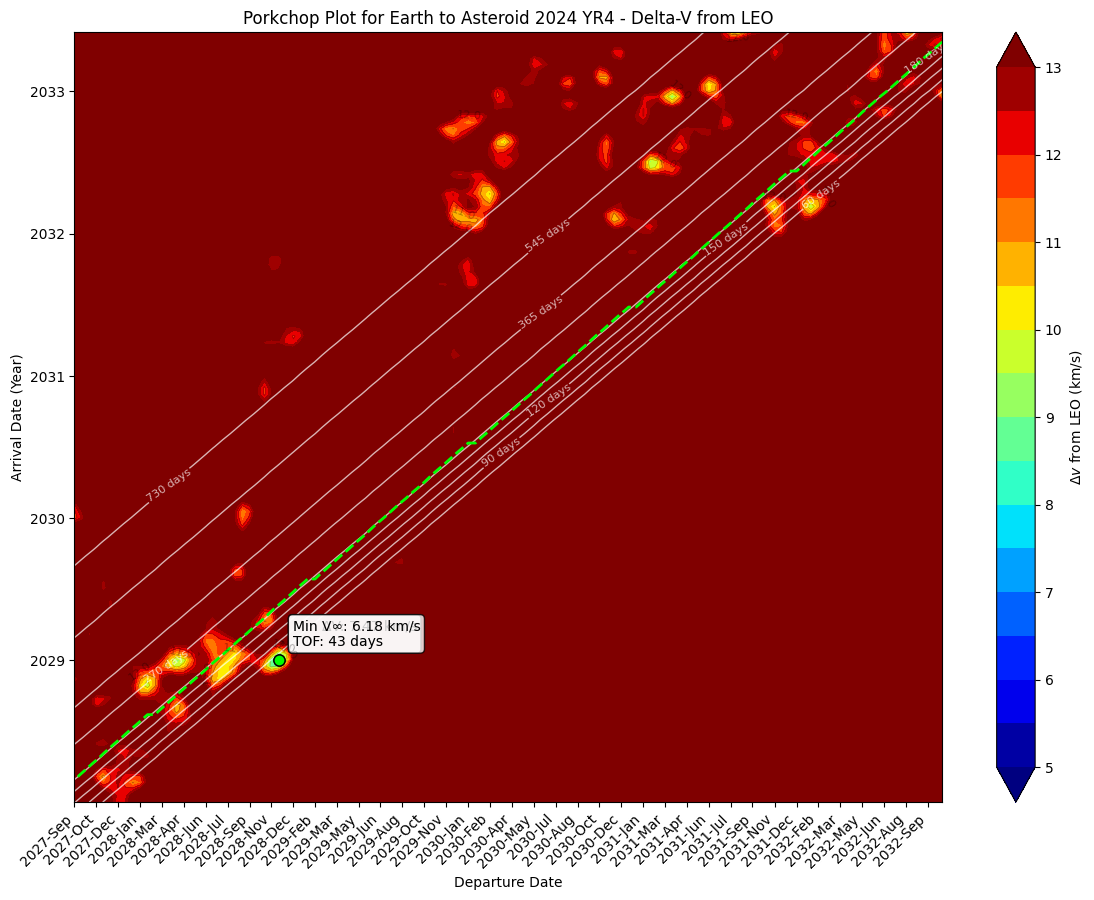

In [14]:
def create_porkchop_plot():
    """Generate a porkchop plot for Earth to asteroid 2024 YR4 transfers"""
    
    # Define departure and arrival date ranges
    departure_start = date_to_et('2027 09 01 12:00:00 UTC')
    departure_end = date_to_et('2032 11 01 12:00:00 UTC')
    
    arrival_start = date_to_et('2028 01 01 12:00:00 UTC')
    arrival_end = date_to_et('2033 06 01 12:00:00 UTC')
    
    # Create grids
    num_points = 120  # Increased from 80 to get more resolution and data points
    departure_times = np.linspace(departure_start, departure_end, num_points)
    arrival_times = np.linspace(arrival_start, arrival_end, num_points)
    
    # Create meshgrid
    DEP, ARR = np.meshgrid(departure_times, arrival_times)
    
    # Initialize matrices with high values
    c3_energy = np.ones(DEP.shape) * 100.0
    delta_v_leo = np.ones(DEP.shape) * 15.0  # Increased to 15 km/s
    v_inf_values = np.ones(DEP.shape) * 10.0
    tof_days = np.ones(DEP.shape) * 0.0
    
    # Calculate values for each departure/arrival pair
    print("Starting calculations...")
    for i in range(num_points):
        if i % 5 == 0:
            print(f"Progress: {i}/{num_points}")
        for j in range(num_points):
            # Skip if arrival is before departure or too close to departure
            if ARR[i, j] <= DEP[i, j]:
                continue
                
            # Calculate time of flight in days
            tof = ARR[i, j] - DEP[i, j]
            tof_days[i, j] = tof / (24 * 3600)
            
            # Skip if the time of flight is too short (less than 20 days instead of 30)
            if tof < 20 * 24 * 3600:  # Reduced minimum TOF to show more short-duration transfers
                continue
            
            # Skip if the time of flight is too long (more than 3 years)
            if tof > 3 * 365 * 24 * 3600:
                continue
            
            # Calculate C3 and delta-v from LEO
            c3, dv_leo, v_inf = calculate_c3_from_leo(DEP[i, j], ARR[i, j])
            
            c3_energy[i, j] = c3
            delta_v_leo[i, j] = dv_leo
            v_inf_values[i, j] = v_inf
    
    print("Calculations completed.")
    
    # Apply smoothing to remove artifacts
    c3_smooth = gaussian_filter(c3_energy, sigma=1.0)
    dv_leo_smooth = gaussian_filter(delta_v_leo, sigma=1.0)
    v_inf_smooth = gaussian_filter(v_inf_values, sigma=1.0)
    
    # Convert ephemeris times to datetime objects
    dep_dates_full = np.array([et_to_date(et) for et in departure_times])
    arr_dates_full = np.array([et_to_date(et) for et in arrival_times])
    
    # Create strings with year and month for x-axis ticks
    dep_dates_labels = [format_year_month(date) for date in dep_dates_full]
    
    # Create numerical values for plotting (year + fraction of year)
    dep_dates = np.array([date.year + date.timetuple().tm_yday/365.0 for date in dep_dates_full])
    arr_dates = np.array([date.year + date.timetuple().tm_yday/365.0 for date in arr_dates_full])
    
    # Create figures
    # Figure 1: Delta-V from LEO
    plt.figure(figsize=(14, 10))
    
    # Define contour levels for delta-v (km/s) - from 5 to 13 as requested
    dv_levels = np.arange(5, 13.5, 0.5)
    
    # Create custom colormap
    cmap = plt.cm.jet
    
    # Plot contours
    cs = plt.contourf(dep_dates, arr_dates, dv_leo_smooth, levels=dv_levels, 
                     cmap=cmap, extend='both')
    
    # Add contour lines
    contour_lines = plt.contour(dep_dates, arr_dates, dv_leo_smooth, 
                             levels=[5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0], 
                             colors='k', linewidths=0.5, alpha=0.3)
    plt.clabel(contour_lines, inline=True, fontsize=8, fmt='%1.1f')
    
    # Add time of flight contours (days) - added more contours for short durations
    tof_contours = plt.contour(dep_dates, arr_dates, tof_days,
                         levels=[60, 90, 120, 150, 180, 270, 365, 545, 730], 
                         colors='white', linewidths=1.0, alpha=0.7)
    plt.clabel(tof_contours, inline=True, fontsize=8, fmt='%d days')
    
    # Add marker for optimal trajectories (minimum Delta-V with short TOF)
    # Find index of minimum delta-v with TOF < 180 days
    short_tof_mask = tof_days < 180
    if np.any(short_tof_mask):
        short_dv = np.copy(dv_leo_smooth)
        short_dv[~short_tof_mask] = np.inf
        min_idx = np.unravel_index(np.argmin(short_dv), short_dv.shape)
        min_dep = dep_dates[min_idx[1]]
        min_arr = arr_dates[min_idx[0]]
        min_dv = dv_leo_smooth[min_idx]
        min_tof = tof_days[min_idx]
        
        # Plot the optimal point
        plt.plot(min_dep, min_arr, 'o', color='lime', markersize=8, markeredgecolor='black')
        plt.annotate(f'Min ΔV: {min_dv:.2f} km/s\nTOF: {min_tof:.0f} days', 
                    (min_dep, min_arr), 
                    xytext=(10, 10), textcoords='offset points',
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))
    
    # Add colorbar
    cbar = plt.colorbar(cs)
    cbar.set_label(r'$\Delta v$ from LEO (km/s)')
    
    # Set labels and title
    plt.xlabel('Departure Date')
    plt.ylabel('Arrival Date (Year)')
    plt.title('Porkchop Plot for Earth to Asteroid 2024 YR4 - Delta-V from LEO')
    
    # Set axis limits based on date ranges
    plt.xlim(min(dep_dates), max(dep_dates))
    plt.ylim(min(arr_dates), max(arr_dates))
    
    # Create custom x-axis ticks with year and month
    # Pick every 3 months for better readability (increased from 4)
    tick_indices = np.arange(0, len(dep_dates), 3)
    tick_positions = dep_dates[tick_indices]
    tick_labels = [dep_dates_labels[i] for i in tick_indices]
    
    plt.xticks(tick_positions, tick_labels, rotation=45, ha='right')
    
    # Create custom x-axis ticks with year and month for V∞ plot
    tick_indices = np.arange(0, len(dep_dates), 3)  # Every 3 months
    tick_positions = dep_dates[tick_indices]
    tick_labels = [dep_dates_labels[i] for i in tick_indices]
    
    plt.xticks(tick_positions, tick_labels, rotation=45, ha='right')
    
    # Highlight short transfers in V∞ plot too
    if np.any(short_tof_mask):
        plt.contour(dep_dates, arr_dates, short_tof_mask.astype(int), 
                   levels=[0.5], colors='lime', linewidths=2.0, 
                   linestyles='dashed')
    
        # Find optimal V∞ with TOF < 180 days
        short_vinf = np.copy(v_inf_smooth)
        short_vinf[~short_tof_mask] = np.inf
        min_vinf_idx = np.unravel_index(np.argmin(short_vinf), short_vinf.shape)
        min_vinf_dep = dep_dates[min_vinf_idx[1]]
        min_vinf_arr = arr_dates[min_vinf_idx[0]]
        min_vinf = v_inf_smooth[min_vinf_idx]
        min_vinf_tof = tof_days[min_vinf_idx]
        
        # Plot the optimal point
        plt.plot(min_vinf_dep, min_vinf_arr, 'o', color='lime', markersize=8, markeredgecolor='black')
        plt.annotate(f'Min V∞: {min_vinf:.2f} km/s\nTOF: {min_vinf_tof:.0f} days', 
                    (min_vinf_dep, min_vinf_arr), 
                    xytext=(10, 10), textcoords='offset points',
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))
        
        # Add legend
        legend_elements = [
            Line2D([0], [0], color='lime', linestyle='dashed', lw=2, label='TOF = 180 days'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor='lime', markersize=8, 
                  markeredgecolor='black', label='Optimal short transfer')
        ]
        plt.legend(handles=legend_elements, loc='upper right')

if __name__ == "__main__":
    try:
        # Load kernels
        load_spice_kernels()
        print("SPICE kernels loaded.")
        # Create porkchop plot
        create_porkchop_plot()
    except Exception as e:
        print(f"Error occurred: {e}")
        import traceback
        traceback.print_exc()
    finally:
        # Clean up kernels
        unload_spice_kernels()
        print("SPICE kernels unloaded.")